In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from loader.DataLoader import read_dataframe
from loader.DataTransformer import lag_list, transform_matrix
from torch import Tensor

In [2]:
# data parameter
LAG = 15

In [3]:
# prepare data
sequence = read_dataframe('all').to_numpy()
sequence = sequence[:, 1:]
# sequence = transform_matrix(sequence, 'DIFF')
# sequence = transform_matrix(sequence, 'NORM')
# sequence[np.isnan(sequence)] = 0 # fill na - there is a column which are all 0

shifted_sequence = lag_list(sequence, LAG + 1)  # shift into delayed sequences

x_train = shifted_sequence[:, :-1, 1:]  # for each delayed sequence, take all elements except last element
y_train = shifted_sequence[:, -1, -1]  # for each delayed sequence, only take the last element
y_train = y_train.reshape(-1, 1)

x_train = torch.from_numpy(x_train.astype('float64')).type(torch.Tensor)  # convert to tensor
y_train = torch.from_numpy(y_train.astype('float64')).type(torch.Tensor)  # convert to tensor

wave_1_x, wave_1_y = x_train[52 -LAG:103 -LAG], y_train[52 -LAG:103 -LAG]
wave_2_x, wave_2_y = x_train[160 -LAG:280 -LAG], y_train[160 -LAG:280 -LAG]
wave_3_x, wave_3_y = x_train[280 -LAG:505 -LAG], y_train[280 -LAG:505 -LAG]
wave_4_x, wave_4_y = x_train[757 -LAG:871 -LAG], y_train[757 -LAG:871 -LAG]

wave_x, wave_y = wave_3_x, wave_3_y

### LSTM Model

In [4]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, embed_size):
        super(Attention, self).__init__()
        self.embed_size = embed_size
        
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

    def forward(self, x, mask=None):
        # Transform inputs to query, key, value
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.embed_size, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        weights = nn.functional.softmax(scores, dim=-1)

        # Compute weighted input
        output = torch.matmul(weights, V)
        
        return output, weights

class Attention_ResidualLstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, lag_nbr, dropout=0):
        super(Attention_ResidualLstmModel, self).__init__()
        self.attention = Attention(lag_nbr)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.residual = nn.Linear(input_size, output_size)
        self.fc2 = nn.Linear(2, output_size)

    def forward(self, x):
        attentioned_x, att_weights = self.attention(x.transpose(-2, -1))  # Apply feature attention
        out, _ = self.lstm(attentioned_x.transpose(-2, -1))
        out = self.fc(out[:, -1, :])
        residual = self.residual(x[:, -1, :]) # last timestamp of output only

        out = self.fc2(torch.cat((out, residual), dim=1))
        return out

In [5]:
class CurveLoss(nn.MSELoss):
    def __init__(self, model, lambda_l1, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)
        self.model = model
        self.lambda_l1 = lambda_l1

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        l1_penalty = 0
        for param in self.model.parameters():
            l1_penalty += torch.sum(torch.abs(param))
        return super().forward(input, target) + torch.square(torch.mean(torch.abs(input - target))) + self.lambda_l1 * l1_penalty

In [6]:
# build model
input_dim = x_train.shape[-1]
hidden_dim = 64
num_layers = 4
output_dim = 1
num_epochs = 3_000

model = Attention_ResidualLstmModel(input_dim, hidden_dim, num_layers, output_dim, LAG)

In [7]:
# 2nd Attention Model
# wave_x, wave_y = wave_3_x, wave_3_y
# hidden_dim = 128
# num_layers = 4
# output_dim = 1
# num_epochs = 3_000

# 3rd Attention Model
# hidden_dim = 64
# num_layers = 4
# output_dim = 1
# num_epochs = 3_000

In [8]:
# train
# num_epochs = 1_000
# loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.L1Loss()
# loss_fn = torch.nn.SmoothL1Loss()
loss_fn = CurveLoss(model, 0)
# optimiser = torch.optim.Adam(model.parameters(), lr=3e-6)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
min_loss = np.inf
best_model_state = None
model.train()

TRAIN_RANGE = int(np.floor(wave_y.shape[0] * 3 / 4))

y_var = np.var(wave_y.numpy().reshape(-1)[:TRAIN_RANGE])
for epoch in range(1, num_epochs + 1):
    y_pred = model(wave_x[:TRAIN_RANGE])
    loss = loss_fn(y_pred, wave_y[:TRAIN_RANGE])
    if epoch % 100 == 0:
        print("Epoch: %d | MSE: %.2E | RRSE: %.2E" % (epoch, loss.item(), np.sqrt(loss.item() / y_var)))
    if min_loss > loss.item():
        best_model_state = copy.deepcopy(model.state_dict())
        min_loss = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch: 100 | MSE: 2.75E+03 | RRSE: 1.64E+00
Epoch: 200 | MSE: 2.16E+03 | RRSE: 1.45E+00
Epoch: 300 | MSE: 1.75E+03 | RRSE: 1.31E+00
Epoch: 400 | MSE: 1.41E+03 | RRSE: 1.18E+00
Epoch: 500 | MSE: 1.27E+03 | RRSE: 1.11E+00
Epoch: 600 | MSE: 1.18E+03 | RRSE: 1.08E+00
Epoch: 700 | MSE: 1.12E+03 | RRSE: 1.05E+00
Epoch: 800 | MSE: 1.05E+03 | RRSE: 1.01E+00
Epoch: 900 | MSE: 9.80E+02 | RRSE: 9.79E-01
Epoch: 1000 | MSE: 9.02E+02 | RRSE: 9.40E-01
Epoch: 1100 | MSE: 8.20E+02 | RRSE: 8.96E-01
Epoch: 1200 | MSE: 6.52E+02 | RRSE: 7.99E-01
Epoch: 1300 | MSE: 2.90E+02 | RRSE: 5.33E-01
Epoch: 1400 | MSE: 2.30E+02 | RRSE: 4.75E-01
Epoch: 1500 | MSE: 2.11E+02 | RRSE: 4.54E-01
Epoch: 1600 | MSE: 2.06E+02 | RRSE: 4.49E-01
Epoch: 1700 | MSE: 1.94E+02 | RRSE: 4.36E-01
Epoch: 1800 | MSE: 1.25E+02 | RRSE: 3.50E-01
Epoch: 1900 | MSE: 8.21E+01 | RRSE: 2.83E-01
Epoch: 2000 | MSE: 7.04E+01 | RRSE: 2.63E-01
Epoch: 2100 | MSE: 6.55E+01 | RRSE: 2.53E-01
Epoch: 2200 | MSE: 6.01E+01 | RRSE: 2.43E-01
Epoch: 2300 | MSE: 

In [9]:
# model.eval()
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [10]:
# num_epochs = 1000

x_test = wave_x[TRAIN_RANGE].reshape(1, LAG, wave_x.shape[2])
y_pred = []
prediction_range = wave_x.shape[0] - TRAIN_RANGE
blind_prediction_range = 7
for j in range(prediction_range // blind_prediction_range + 1):
    train_start_index = TRAIN_RANGE + j * blind_prediction_range
    for i in range(blind_prediction_range):
        if train_start_index + i >= len(wave_x):
            break
        _ = model(x_test)
        x_test = wave_x[train_start_index + i].reshape(1, LAG, wave_x.shape[2])
        x_test[0][-1][0] = torch.tensor(_.item())
        _2 = _.detach().numpy()  # revert from tensor
        _2 = _2.reshape(-1)  # reshape back to normal list
        y_pred.append(_2)
    for epoch in range(1, num_epochs + 1):
        _3 = model(wave_x[train_start_index : train_start_index + blind_prediction_range])
        loss = loss_fn(_3, wave_y[train_start_index : train_start_index + blind_prediction_range])
        if epoch % 100 == 0:
            print("Epoch: %d | MSE: %.2E | RRSE: %.2E" % (epoch, loss.item(), np.sqrt(loss.item() / y_var)))
        if min_loss > loss.item():
            best_model_state = copy.deepcopy(model.state_dict())
            min_loss = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

y_pred = np.array(y_pred).reshape(-1)  # reshape back to normal list
print("sample prediction:  ", y_pred)

y_train_sample = wave_y[TRAIN_RANGE:].detach().numpy().reshape(-1)[:prediction_range]
print("sample true result: ", y_train_sample)

mse = sum((y_train_sample - y_pred) ** 2) / len(y_pred)
rmse = mse / np.var(y_train_sample)
print("TEST | MSE: %.2E | RRSE: %.2E" % (mse, rmse))

Epoch: 100 | MSE: 3.58E+01 | RRSE: 1.87E-01
Epoch: 200 | MSE: 3.55E+01 | RRSE: 1.87E-01
Epoch: 300 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 400 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 500 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 600 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 700 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 800 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 900 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1000 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1100 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1200 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1300 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1400 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1500 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1600 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1700 | MSE: 3.55E+01 | RRSE: 1.86E-01
Epoch: 1800 | MSE: 3.54E+01 | RRSE: 1.86E-01
Epoch: 1900 | MSE: 3.54E+01 | RRSE: 1.86E-01
Epoch: 2000 | MSE: 3.54E+01 | RRSE: 1.86E-01
Epoch: 2100 | MSE: 3.54E+01 | RRSE: 1.86E-01
Epoch: 2200 | MSE: 3.54E+01 | RRSE: 1.86E-01
Epoch: 2300 | MSE: 

In [11]:
y_pred_lstm = copy.deepcopy(y_pred)
mse_lstm = mse

### Plot Result

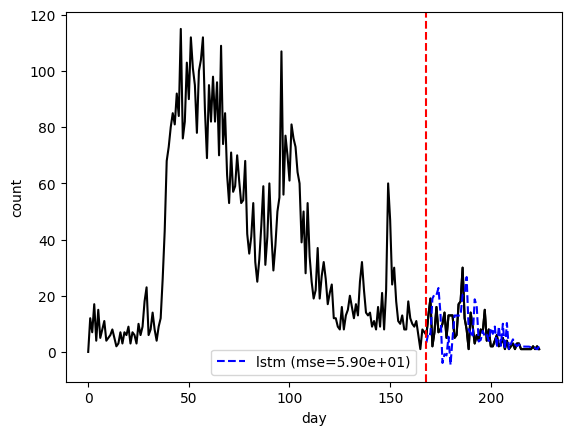

In [12]:
y_given = wave_y.detach().numpy().reshape(-1)
plt.plot(range(len(y_given)), y_given, color='black')
plt.plot(range(TRAIN_RANGE, len(y_given)), y_train_sample, color='black')
plt.plot(range(TRAIN_RANGE, len(y_given)), y_pred_lstm, 'b--', label='lstm (mse={mse:.2e})'.format(mse=mse_lstm))
plt.axvline(x=TRAIN_RANGE, linestyle='--', color='red')
plt.ylabel("count")
plt.xlabel("day")
plt.legend()
plt.show()

In [13]:
f = nn.Linear(2,3)

In [14]:
f.weight.data

tensor([[-0.0964, -0.5463],
        [ 0.4974,  0.7015],
        [-0.5005, -0.2727]])

In [16]:
a = torch.tensor([[1.0, 2.0]], dtype=torch.float32)

In [15]:
f.bias.data

tensor([-0.0463,  0.0857,  0.7063])

In [17]:
f(a)

tensor([[-1.2353,  1.9860, -0.3396]], grad_fn=<AddmmBackward0>)

In [24]:
-0.0964 - 0.5463*2 - 0.0463

-1.2353